# Decoding circuits for stabilizer codes

<div style="width:100%;text-align:right;font-size:0.75em;opacity:0.2">Latex macros</div>
$\newcommand{\ket}[1]{|#1\rangle} $
$\newcommand{\bra}[1]{\langle #1|} $
$\newcommand{\iu}{{i\mkern1mu}}$
$\newcommand{\e}{\mathrm{e}}$
$\newcommand{\bigo}{\mathcal{O}}$
$\newcommand{\set}[1]{\{#1\}}$
$\newcommand{\oper}[1]{\mathcal{#1}}$
$\newcommand{\st}[1]{\mathcal{#1}}$
$\newcommand{\vecs}[1]{\mathcal{#1}}$
$\newcommand{\group}[1]{\mathcal{#1}}$
$\newcommand{\union}{\hspace{0.25em}\cup\hspace{0.25em}}$

Decoding is not an important part of error correction when quantum error correction is employed to protect against noise during the execution of quantum algorithms. We do all operations - logical operations, error correction and measurement of the output of the computation - on the encoded states themselves. Therefore, decoding is not required at all.

However, it's used in quantum communication protocols, so it is worth studying.

### Simple way of decoding
The simple way of decoding is to just run the encoding circuit in reverse. This will work perfectly. We will first encode a random state and then decode it.

In [1]:
import stac
cd = stac.CommonCodes.generate_code('[[7,1,3]]')
cd.construct_encoding_circuit();

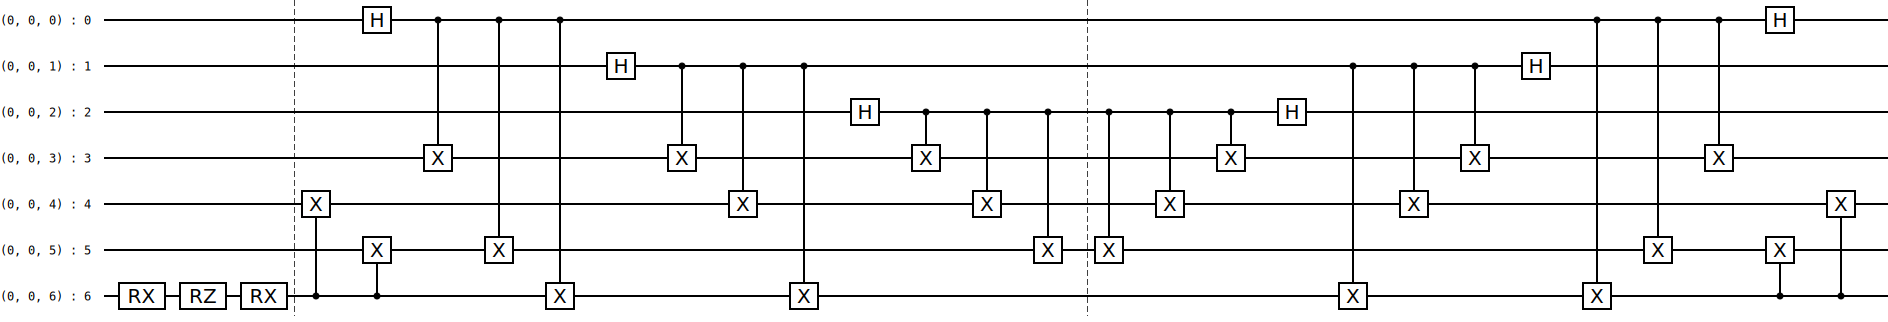

  basis  input state    enc state      dec state
-------  -------------  -------------  -------------
0000000  -0.401-0.798j  -0.142-0.282j  -0.401-0.798j
1111000                 -0.142-0.282j
0110100                  0.137-0.081j
1001100                  0.137-0.081j
1010010                  0.137-0.081j
0101010                  0.137-0.081j
1100110                 -0.142-0.282j
0011110                 -0.142-0.282j
0000001   0.387-0.230j                  0.387-0.230j
1100001                  0.137-0.081j
0011001                  0.137-0.081j
1010101                 -0.142-0.282j
0101101                 -0.142-0.282j
0110011                 -0.142-0.282j
1001011                 -0.142-0.282j
0000111                  0.137-0.081j
1111111                  0.137-0.081j


In [2]:
from random import random
from math import pi
circ = stac.Circuit.simple(7)
circ.append('rx', 6, random()*pi)
circ.append('rz', 6, random()*pi)
circ.append('rx', 6, random()*pi)

# TICK annotations will allow us to simulate 
# the circuit up to every TICK
# In the table below the second column has the
# state upto this TICK
circ.append('TICK')

# then encode it.
circ += cd.encoding_circuit
# In the table below, the third column has the
# state upto this TICK
circ.append('TICK')

# then decode
rev_enc_circ = cd.encoding_circuit.reverse()
circ += rev_enc_circ
# # The fourth column shows the state at this
# # final point

# draw it
circ.draw()

# then simulate it
circ.simulate(head=['basis', 'input state','enc state', 'dec state'], incremental=True)

You can see that, as expected, the state decodes correctly. Run this cell a few times to convince yourself.

### Gottesman's decoding algorithm
Gottesman's decoding algorithm is quite simple, and again employs the standard form of the stabilizer generator matrix that we computed last time. Instead of decoding in place, we will add $k$ (number of logical qubits) ancilla to our circuit and put the decoded state there. The steps are

1. Compute the standard form of the generator matrix.
2. Determine the logical $\bar{X}$ and logical $\bar{Z}$ operations.
3. Use the following algorithm to determine the decoding circuit.

```
decoding_circuit = []

for i in range(len(logical_zs)):
    for j in range(n):
        if logical_zs[i, n+j]:
            decoding_circuit.append(["cx", j, n+i])

for i in range(len(logical_xs)):
    for j in range(n):
        if logical_xs[i, j] and logical_xs[i, n+j]:
            decoding_circuit.append(["cz", n+i, j])
            decoding_circuit.append(["cx", n+i, j])
        elif logical_xs[i, j]:
            decoding_circuit.append(["cx", n+i, j])
        elif logical_xs[i, n+j]:
            decoding_circuit.append(["cz", n+i, j])
```
As you can see, this algorithm just reads off the entries of the logical operators, and applies appropriate control operations to and from the ancilla qubits.

*Question:* Determine the number of operations required for Gottesman's encoding algorithm. What is the depth of the circuit? Determine the number of operations required for Gottesman's decoding algorithm. What is the depth of the circuit? 

Now, let's try this.

G =


<IPython.core.display.Math object>

Logical X =


<IPython.core.display.Math object>

Logical Z =


<IPython.core.display.Math object>

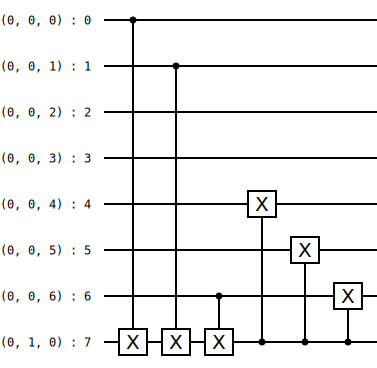

In [3]:
cd.construct_standard_form()
print("G =")
stac.print_matrix(cd.standard_generator_matrix, augmented=True)
cd.construct_logical_operators()
print("Logical X =")
stac.print_matrix(cd.logical_xs, augmented=True)
print("Logical Z =")
stac.print_matrix(cd.logical_zs, augmented=True)

dec_circ = cd.construct_decoding_circuit()

dec_circ.draw()

Does this actually work? Let's try. It will be a bit difficult to see the working of this algorithm with random states, so let's work with the basis states. First, we will see if the zero state is decoded properly.

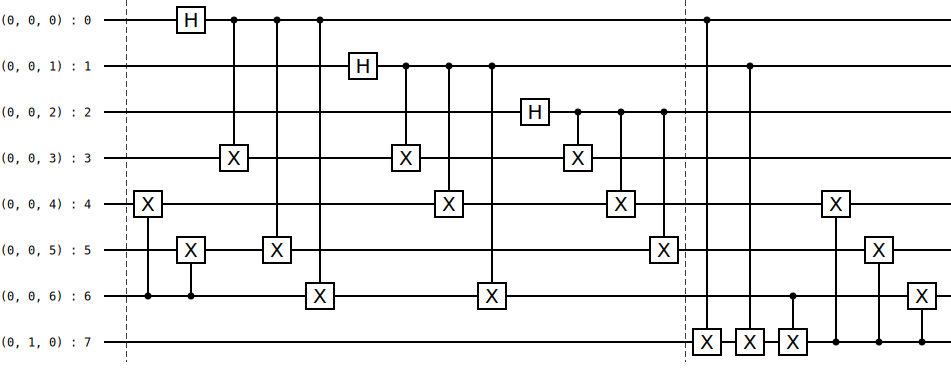

   basis  input state      enc state    dec state
--------  -------------  -----------  -----------
00000000   1.000               0.354        0.354
11110000                       0.354        0.354
11001100                       0.354        0.354
00111100                       0.354        0.354
10101010                       0.354        0.354
01011010                       0.354        0.354
01100110                       0.354        0.354
10010110                       0.354        0.354


In [4]:
cd.construct_encoding_circuit()

# first create the zero state
circ = stac.Circuit.simple(cd.num_data_qubits)
circ.append_register(stac.QubitRegister('a', 0, cd.num_logical_qubits))
circ.append('TICK')

# then encode it.
circ += cd.encoding_circuit
circ.append('TICK')

# then decode
circ += cd.decoding_circuit

circ.draw()
circ.simulate(head=['basis', 'input state','enc state', 'dec state'], incremental=True)

The input state here is the $7$th qubit counting from the left, out of the $8$ qubits. The first $6$ qubits are the encoding ancilla, and the last qubit is the decoding ancilla.

You can see that the input state is $\ket{0000000}\ket{0}$. Then, we apply the encoding operation to get the encoded $\ket{\bar 0}$ state. After decoding, note that the state of the $8$th qubit is still $0$. This is not very interesting now. But, let's try with the one state.

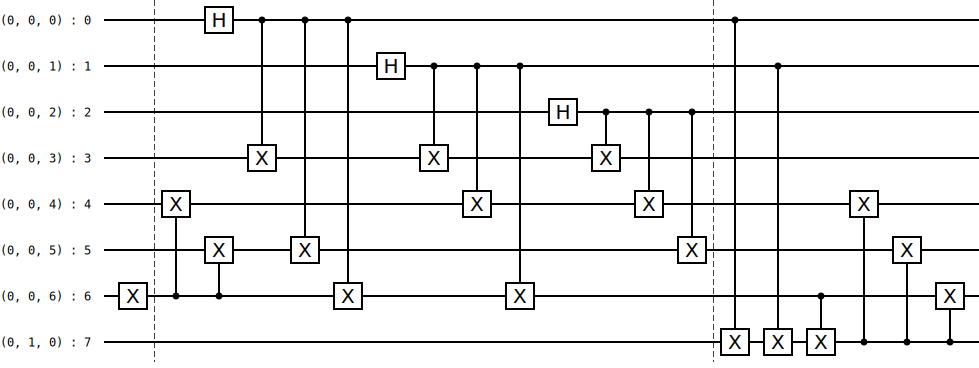

   basis  input state    enc state    dec state
--------  -------------  -----------  -----------
01101000                  0.354
10011000                  0.354
10100100                  0.354
01010100                  0.354
00000010   1.000
11000010                  0.354
00110010                  0.354
00001110                  0.354
11111110                  0.354
00000001                               0.354
11110001                               0.354
11001101                               0.354
00111101                               0.354
10101011                               0.354
01011011                               0.354
01100111                               0.354
10010111                               0.354


In [5]:
# first create the one state
circ = stac.Circuit.simple(cd.num_data_qubits)
circ.append_register(stac.QubitRegister('a', 0, cd.num_logical_qubits))
circ.append('X',6)
circ.append('TICK')

# then encode it.
circ += cd.encoding_circuit
circ.append('TICK')

# then decode
circ += cd.decoding_circuit

circ.draw()
circ.simulate(head=['basis', 'input state','enc state', 'dec state'], incremental=True)

And voila, you see that in the final state, the $8$th qubit is in the state $\ket{1}$, hence unentangled from the remaining qubits. Also, note that the state of the first $7$ qubits has changed into something outside the logical code space (none of the kets that appear in the logical zero and one states are here). This ensures that the first $7$ qubits no longer contain any information about an arbitrary logical qubit, hence, respecting the no-cloning theorem.

#### Task 1
Decode the zero and one state for the $[[5,1,3]]$ code, and make sure you get the right answer.